In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib notebook

In [2]:
## LOAD SOME DATA

def load_data(dirname):
    NDAYS = 14 # == number of files
    filenames = os.listdir(dirname)
    filenames.sort() #make sure they are ordered
    X = pd.read_parquet(os.path.join(dirname,filenames[0]))#,filters=[('datetime','>','2019-03-01'),('datetime','<','2019-04-01')])
    for n in range(1,NDAYS):
        print('on day {}/{}'.format(n, NDAYS-1))
        X = X.append(pd.read_parquet(os.path.join(dirname,filenames[n])),ignore_index=True)
    
    return X

client_data = []

file_names = ['BEBUEE03', 'BEBUEE04', 'BEBUEE01']
data_location = '../BEBUE'
num_of_repeats = 5
num_of_fl_rounds = 500
num_of_clients = len(file_names)

for fname in file_names:
    client_data.append(load_data(dirname=os.path.join(data_location, fname)))


on day 1/13
on day 2/13
on day 3/13
on day 4/13
on day 5/13
on day 6/13
on day 7/13
on day 8/13
on day 9/13
on day 10/13
on day 11/13
on day 12/13
on day 13/13
on day 1/13
on day 2/13
on day 3/13
on day 4/13
on day 5/13
on day 6/13
on day 7/13
on day 8/13
on day 9/13
on day 10/13
on day 11/13
on day 12/13
on day 13/13
on day 1/13
on day 2/13
on day 3/13
on day 4/13
on day 5/13
on day 6/13
on day 7/13
on day 8/13
on day 9/13
on day 10/13
on day 11/13
on day 12/13
on day 13/13


<IPython.core.display.Javascript object>


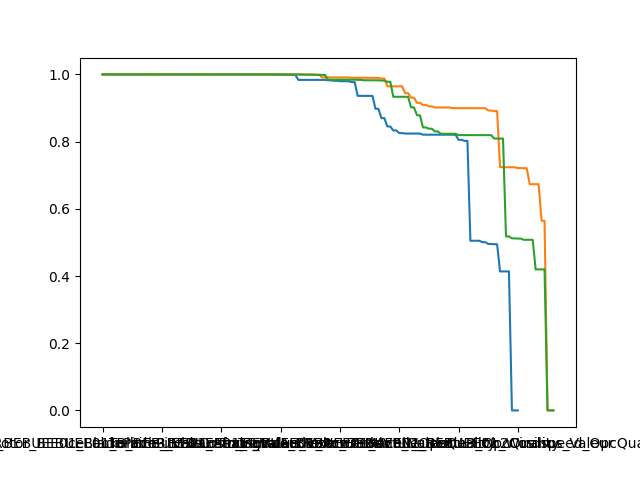

In [3]:
## Some missing data analysis
for data in client_data:
    (data.isna().sum(axis=0)/data.shape[0]).sort_values(ascending=False).plot()

In [4]:
def clean_names(pd_data, string_to_remove):
    new_column_names = {}
    for col_name in pd_data.columns:
        # print(col_name)
        split_names = col_name.split('_')
        if string_to_remove in split_names:
            if len(split_names) > 1:
                # print(split_names)
                split_names.remove(string_to_remove)
                new_name = '_'.join(split_names)
                new_column_names[col_name] = new_name
    return pd_data.rename(columns=new_column_names)

for client_num, (data, str_to_remove) in enumerate(zip(client_data, file_names)):
    client_data[client_num] = clean_names(pd_data=data, string_to_remove=str_to_remove)

In [5]:
## Let's focus on columns without too many missing data

MaxMissingRatio = 0.9

'''
We will use client 0 to determine which features to use accross all clients.
'''

columns_to_keep = client_data[0].isna().sum(axis=0)[client_data[0].isna().sum(axis=0)/client_data[0].shape[0] <= MaxMissingRatio].index.values.tolist()

## Quality columns analysis
columns_to_keep_quality = [c for c in columns_to_keep if c.endswith('OpcQuality')]

print('Unique values in quality columns:')
for c in columns_to_keep_quality:
    print('%s: %r' % (c,client_data[0][c].unique()))
    
## Remove quality columns from columns_to_keep 
[ columns_to_keep.remove(el) for el in columns_to_keep_quality]
## Remove metadata columns from columns_to_keep
columns_to_keep.remove('mac_code')
columns_to_keep.remove('parc_code')
print(columns_to_keep)

Unique values in quality columns:
ComEolToPoste_Active_Power_OpcQuality: array([192.,  nan])
Convert_CosPhi_OpcQuality: array([192.,  nan])
Generatrice_GenSpeed_OpcQuality: array([192.,  nan])
Nacelle_AbsWindDirect_OpcQuality: array([192.,  nan])
Nacelle_AbsWindDirectCosinus_OpcQuality: array([192.,  nan])
Nacelle_AbsWindDirectSinus_OpcQuality: array([192.,  nan])
Nacelle_HydPres_OpcQuality: array([192.,  nan])
Nacelle_NacelleAngleCosinus_OpcQuality: array([192.,  nan])
Nacelle_NacelleAngleSinus_OpcQuality: array([192.,  nan])
Nacelle_Windspeed_OpcQuality: array([192.,  nan])
Rotor_BladePitch1_OpcQuality: array([192.,  nan])
Rotor_BladePitch1Cosinus_OpcQuality: array([192.,  nan])
Rotor_BladePitch1Sinus_OpcQuality: array([192.,  nan])
Rotor_BladePitch2_OpcQuality: array([192.,  nan])
Rotor_BladePitch2Cosinus_OpcQuality: array([192.,  nan])
Rotor_BladePitch2Sinus_OpcQuality: array([192.,  nan])
Rotor_BladePitch3_OpcQuality: array([192.,  nan])
Rotor_BladePitch3Cosinus_OpcQuality: array(

In [6]:
## Data preparation
# > Resample to make regular
# > remove outliers (eg negative active power)
# > interpolate missing data 

# Set datetime index and make column names simpler
def data_preparation(X):
    Xclean = X[columns_to_keep].copy()
    Xclean.set_index('date',inplace=True)
    Xclean.rename(columns={el:el.split('_')[1] for el in Xclean.columns},inplace=True)

    # Resample to regular 1s, by upsampling to 0.1s and interpolating to 1s (limit to 2 sec missing data)
    print('Missing data ratio before resampling: ')
    print(Xclean.isna().sum(axis=0)/Xclean.shape[0])
    Xclean = Xclean.resample('.1S').nearest(limit=1).interpolate('linear',limit=40,limit_area='inside').resample('1S').asfreq()
    print('Missing data ratio after resampling: ')
    print(Xclean.isna().sum(axis=0)/Xclean.shape[0])

    # Remove negative instances of Active Power
    Xclean['ActPow'].loc[Xclean['ActPow']<0] = np.nan
    
    return Xclean


for client_num, data in enumerate(client_data):
    client_data[client_num] = data_preparation(X=data)


Missing data ratio before resampling: 
Active                  0.825325
CosPhi                  0.897576
GenSpeed                0.805369
AbsWindDirect           0.802129
AbsWindDirectCosinus    0.413666
AbsWindDirectSinus      0.413630
HydPres                 0.845074
NacelleAngleCosinus     0.504902
NacelleAngleSinus       0.504902
Windspeed               0.494509
BladePitch1             0.823980
BladePitch1Cosinus      0.820586
BladePitch1Sinus        0.820484
BladePitch2             0.823980
BladePitch2Cosinus      0.820586
BladePitch2Sinus        0.820484
BladePitch3             0.823980
BladePitch3Cosinus      0.820586
BladePitch3Sinus        0.820484
RotSpeed                0.869851
ActPow                  0.495359
AvailablePower          0.833236
ReactPow                0.500840
dtype: float64
Missing data ratio after resampling: 
Active                  0.264140
CosPhi                  0.571721
GenSpeed                0.213740
AbsWindDirect           0.200048
AbsWindDirectCosi

<IPython.core.display.Javascript object>


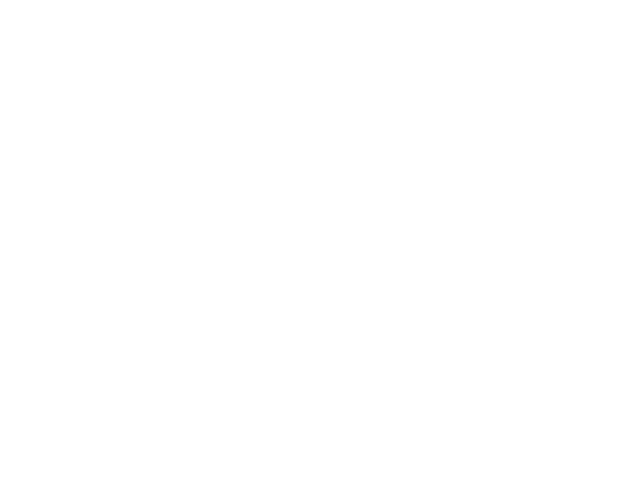

<IPython.core.display.Javascript object>


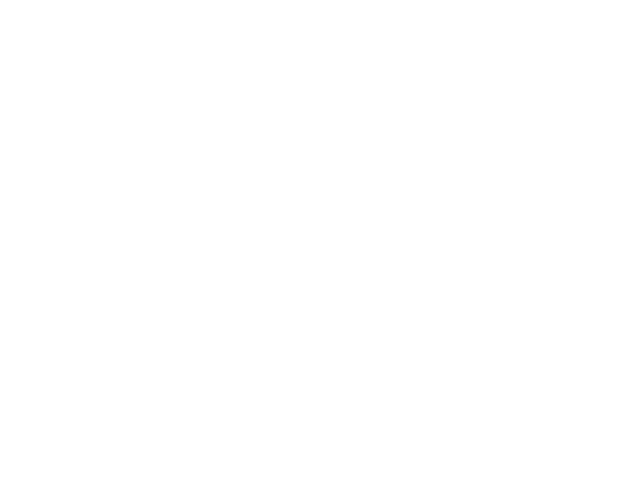

<IPython.core.display.Javascript object>


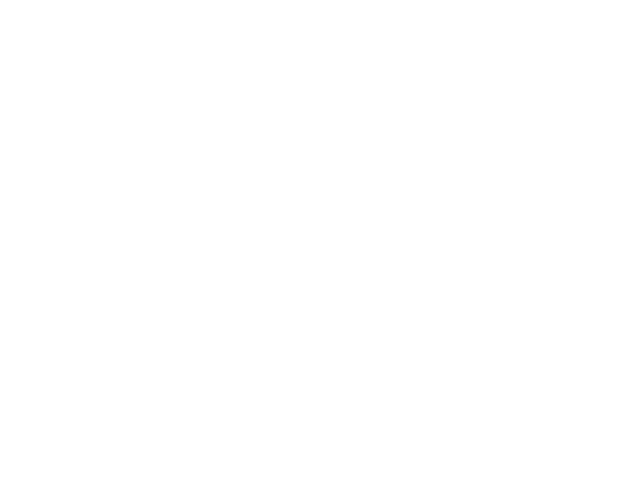

In [7]:
## Difference between columns Active and ActivePow ?
def diff_between_features(X, feature_1, feature_2):
    Npoints = 10000
    ix = np.random.randint(0,X.shape[0],Npoints)
    X[[feature_1, feature_2]].iloc[ix].plot.scatter(0,1)

for data in client_data:
    diff_between_features(X=data, feature_1='Active', feature_2='ActPow')

<IPython.core.display.Javascript object>


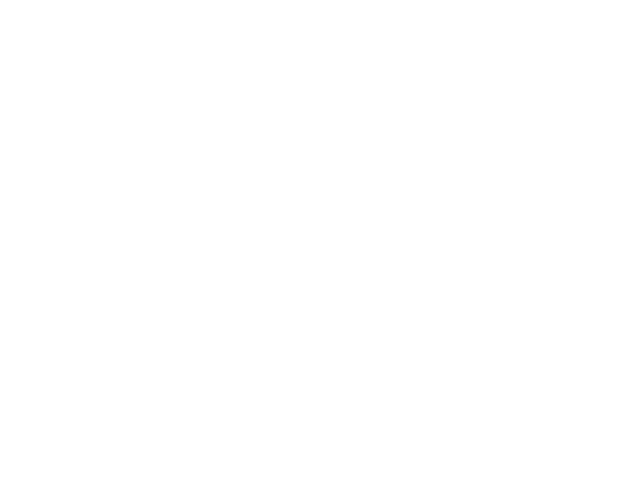

<IPython.core.display.Javascript object>


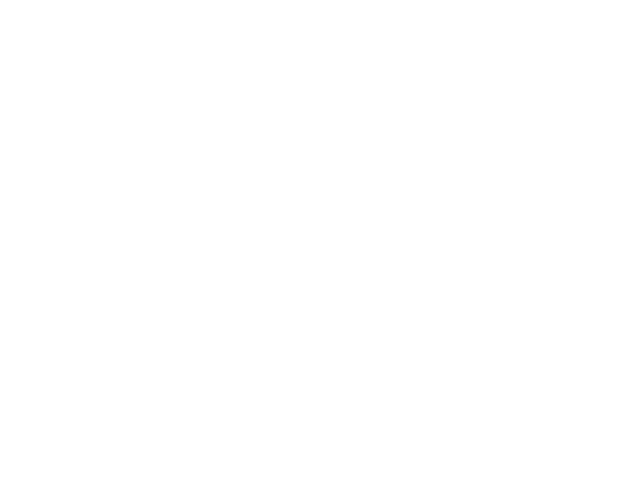

<IPython.core.display.Javascript object>


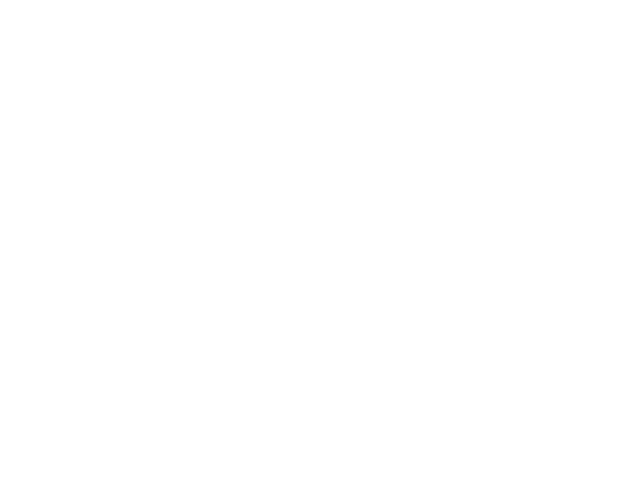

In [8]:
## Difference between columns Active and AvailablePower ?
for data in client_data:
    diff_between_features(X=data, feature_1='Active', feature_2='AvailablePower')

In [9]:
## Correlation matrix
for data in client_data:
    data.dropna().corr()[['Active','ActPow','AvailablePower']]

In [10]:
'''
Fl
'''
from sklearn.utils import shuffle

def data_preprocess(Xclean):
    NTR = int(7* (3600*24)) # days at 1 second resolution

    features = Xclean.columns.tolist()
    features.remove('Active')
    features.remove('AvailablePower')
    features.remove('ActPow')
    target = 'ActPow'

    Xt = Xclean.iloc[:NTR].dropna()

    x_data = copy.copy(Xt[features])
    y_data = copy.copy(Xt[target])

    scaler = StandardScaler()
    scaler.fit(x_data)
    x_data = scaler.transform(x_data)

    y_data = np.asarray(y_data)
    y_data = y_data.reshape(-1, 1)
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(y_data)
    y_data = min_max_scaler.transform(y_data)
    
    train_split = int(len(x_data)*0.8)
    
    train_x_data = x_data[:train_split]
    train_y_data = y_data[:train_split]
    
    train_x_data, train_y_data = shuffle(train_x_data, train_y_data)
    
    valid_split = int(len(x_data)*0.1)

    valid_x_data = train_x_data[:valid_split]
    valid_y_data = train_x_data[:valid_split]
    
    train_x_data = train_x_data[valid_split:]
    train_y_data = train_y_data[valid_split:]

    test_x_data = x_data[valid_split:]
    test_y_data = y_data[valid_split:]

    return train_x_data, train_y_data, valid_x_data, valid_y_data, test_x_data, test_y_data

train_x = []
train_y = []

valid_x = []
valid_y = []

test_x = []
test_y = []

for data in client_data:
    train_x_data, train_y_data, valid_x_data, valid_y_data, test_x_data, test_y_data = data_preprocess(data)

    train_x.append(train_x_data)
    train_y.append(train_y_data)
    
    valid_x.append(train_x_data)
    valid_y.append(train_y_data)

    test_x.append(test_x_data)
    test_y.append(test_y_data)

'''
we make centralised versions of the datasets for comparison in various benchmarks.
'''
x_central_dataset = np.concatenate(train_x)
y_central_dataset = np.concatenate(train_y)

x_central_valid = np.concatenate(valid_x)
y_central_valid = np.concatenate(valid_y)

x_central_test = np.concatenate(test_x)
y_central_test = np.concatenate(test_y)

In [11]:
import torch
import torch.optim as optim
import random

from torch import nn
from sklearn.metrics import r2_score
from typing import Optional

random.seed(123)
torch.manual_seed(123)
np.random.seed(123)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [12]:
def client_train_loop(model, opt, criterion, x, y, valid_x=None, valid_y=None, 
                      bsize=32, return_best=False, 
                      max_num_of_updates=None, local_rounds=1):
    """
    :param model: pytorch model
    :param opt: pytorch optimiser
    :param x, y: numpy arrays of training - labels
    :param criterion: loss function
    :param bsize: batch size
    :param max_num_of_updates: If we want to run for a particular number of batches per local round. 
                               Eg max_num_of_updates=1 and local_rounds=1 equates to gradient averaging 
                               from a single update. 
    :param local_rounds: number of local epochs to run over the data.
    """

    num_of_batches = int(len(x) / bsize)

    if max_num_of_updates is not None:
        if max_num_of_updates <= num_of_batches:
            num_of_batches = max_num_of_updates
    
    for epoch in range(local_rounds):
        x, y = shuffle(x, y)
        for bnum in range(num_of_batches):

            x_batch = np.copy(x[bsize*bnum:(bnum+1)*bsize])
            y_batch = np.copy(y[bsize*bnum:(bnum+1)*bsize])

            x_batch = torch.from_numpy(x_batch).type(torch.FloatTensor).to(device)
            y_batch = torch.from_numpy(y_batch).type(torch.FloatTensor).to(device)

            opt.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            opt.step()

        if return_best and valid_x is not None and valid_y is not None:
            preds = model(valid_x)
            valid_loss = criterion(preds, torch.from_numpy(valid_y).type(torch.FloatTensor).to(device))
            if epoch > 0:
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    best_weights = copy.deepcopy(model.state_dict())
            else:
                best_loss = valid_loss
                best_weights = copy.deepcopy(model.state_dict())

    if return_best:
        model.load_state_dict(best_weights)

    return model, opt

In [13]:
class PytorchModel(nn.Module):
    def __init__(self):
        super(PytorchModel, self).__init__()
        self.fc1 = nn.Linear(in_features=20,
                             out_features=5)
        self.fc2 = nn.Linear(in_features=5,
                             out_features=5)
        self.fc3 = nn.Linear(in_features=5,
                     out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).type(torch.FloatTensor).to(device)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def fed_average(global_model, client_models, agg_mode='mean'):
    for param_tensor in global_model.state_dict():
        new_weights = []
        for state_dict in client_models:
            new_weights.append(state_dict[param_tensor].data.cpu().numpy())
        
        new_weights = np.asarray(new_weights)
        
        if agg_mode == 'mean':
            new_weights = np.mean(new_weights, axis=0)
        elif agg_mode == 'median':
            new_weights = np.median(new_weights, axis=0)
        else:
            raise ValueError('Selected agg_mode not supported. Only mean and median')

        global_model.state_dict()[param_tensor][:] = torch.Tensor(np.copy(new_weights)).to(device)
    return global_model

In [15]:
'''
central version: all data is available on one device and a model trained. Represents upper limit of performance.
'''
def run_central_training(x, y, val_x, val_y, bsize=200, local_rounds=500):
    model = PytorchModel().to(device)
    criterion = nn.MSELoss()
    opt = optim.SGD(model.parameters(), lr=1e-2)

    model, opt = client_train_loop(model=model,
                                   opt=opt,
                                   x=x,
                                   y=y,
                                   valid_x=val_x,
                                   valid_y=val_y,
                                   return_best=True,
                                   criterion=criterion,
                                   bsize=bsize,
                                   local_rounds=local_rounds)
    return model


central_scores = []
for run in range(num_of_repeats):
    model = run_central_training(x=x_central_dataset, 
                                 y=y_central_dataset, 
                                 val_x=x_central_valid,
                                 val_y=y_central_valid)
    
    preds = model(x_central_test)
    central_run_score = r2_score(y_true=y_central_test, y_pred=preds.cpu().detach().numpy())
    print('Central score on run {} is {}'.format(run, central_run_score))
    
    central_scores.append(central_run_score)

print('The mean central score is {} with std {}'.format(np.mean(central_scores), np.std(central_scores)))

Central score on run 0 is 0.9113430192721493
Central score on run 1 is 0.9122883272238546
Central score on run 2 is 0.9076682368882164
Central score on run 3 is 0.8969477232042152
Central score on run 4 is 0.9086398954149053
The mean central score is 0.907377440400668 with std 0.0054826997224763745


In [16]:
'''
local version: each client trains on local data from scratch.
'''
num_of_clients = 3
local_data_client_scores = np.zeros((5, num_of_clients)) # how well each client does on its own data
central_data_client_scores = np.zeros((5, num_of_clients)) # how well each client does on all the combined test data

for client_num, (x_data, y_data, x_valid, y_valid) in enumerate(zip(train_x, train_y, valid_x, valid_y)):
    for run in range(num_of_repeats):
        model = run_central_training(x=x_data,
                                     y=y_data,
                                     val_x=x_valid,
                                     val_y=y_valid)

        preds = model(test_x[client_num])
        local_score = r2_score(y_true=test_y[client_num], y_pred=preds.cpu().detach().numpy())
        print('Client {}: test score on local data is {}'.format(client_num, local_score))
        
        local_data_client_scores[run, client_num] = local_score
        
        preds = model(x_central_test)
        aggregated_score = r2_score(y_true=y_central_test, y_pred=preds.cpu().detach().numpy())
        print('Client {}: test score on all test data is {}'.format(client_num, aggregated_score))
        
        central_data_client_scores[run, client_num] = aggregated_score
    
    print('\n%-----------------------%')
    print('Results for client {} are:'.format(client_num))
    print('On local data {}, std {} '.format(np.mean(local_data_client_scores[:, client_num]),
                                             np.std(local_data_client_scores[:, client_num])))
    
    print('On test data {}, std {} '.format(np.mean(central_data_client_scores[:, client_num]),
                                            np.std(central_data_client_scores[:, client_num])))
    print('%-----------------------%\n')

Client 0: test score on local data is 0.9087229161282002
Client 0: test score on all test data is 0.8939644420744218
Client 0: test score on local data is 0.8943812779388413
Client 0: test score on all test data is 0.8853419534999319
Client 0: test score on local data is 0.9073895201150236
Client 0: test score on all test data is 0.8866198148420005
Client 0: test score on local data is 0.9094231139600737
Client 0: test score on all test data is 0.8807597342348035
Client 0: test score on local data is 0.903924673942586
Client 0: test score on all test data is 0.8915423634646064

%-----------------------%
Results for client 0 are:
On local data 0.904768300416945, std 0.005527730254624732 
On test data 0.887645661623153, std 0.004666619769502138 
%-----------------------%

Client 1: test score on local data is 0.9083507298773408
Client 1: test score on all test data is 0.9005583630893319
Client 1: test score on local data is 0.9110985038528662
Client 1: test score on all test data is 0.90

In [17]:
'''
federated version: both clients participate in a FL setting.
'''
fl_r2_training_scores = []
fl_test_scores = [] 
fl_local_data_scores = np.zeros((5, num_of_clients)) # how well the fl model performs on the clients local test data.

for run in range(num_of_repeats):
    model = PytorchModel().to(device)
    criterion = nn.MSELoss()
    opt = optim.SGD(model.parameters(), lr=1e-2)
    r2_scores_list = []

    for round_num in range(num_of_fl_rounds):
        # fl loop:
        client_models = []
        initial_state_dic = copy.deepcopy(model.state_dict())

        for x_data, y_data in zip(train_x, train_y):
            model.load_state_dict(initial_state_dic)

            model, opt = client_train_loop(model=model,
                                           opt=opt,
                                           x=x_data,
                                           y=y_data,
                                           criterion=criterion,
                                           bsize=200,
                                           local_rounds=1)

            client_models.append(copy.deepcopy(model.state_dict()))

        model = fed_average(global_model=model, 
                            client_models=client_models, 
                            agg_mode='mean')

        
        # log performance over training
        client_results = []
        for client_num, (x_valid_data, y_vaid_data) in enumerate(zip(valid_x, valid_y)):
            preds = model(x_valid_data)
            score = r2_score(y_true=y_vaid_data, y_pred=preds.cpu().detach().numpy())
            if round_num % 100 == 0:
                print('Client {}: at end of round {} the score is {}'.format(client_num, round_num, score))
            client_results.append(score)
        r2_scores_list.append(client_results)
    
    print('\n%-----------------------%')
    for client_num, (x_test_data, y_test_data) in enumerate(zip(test_x, test_y)):
        preds = model(x_test_data)
        score = r2_score(y_true=y_test_data, y_pred=preds.cpu().detach().numpy())
        print('Client {}: test score is {}'.format(client_num, score))
        fl_local_data_scores[run, client_num] = score

    preds = model(x_central_test)
    fl_combined_score = r2_score(y_true=y_central_test, y_pred=preds.cpu().detach().numpy())
    print('Central score is {}'.format(fl_combined_score))
    print('%-----------------------%\n')
    
    fl_r2_training_scores.append(r2_scores_list)
    fl_test_scores.append(fl_combined_score)



Client 0: at end of round 0 the score is 0.6570619677904908
Client 1: at end of round 0 the score is 0.663467678981276
Client 2: at end of round 0 the score is 0.6810507112502344
Client 0: at end of round 100 the score is 0.8836375720459436
Client 1: at end of round 100 the score is 0.8993236838830467
Client 2: at end of round 100 the score is 0.9228877783557503
Client 0: at end of round 200 the score is 0.8923980310864458
Client 1: at end of round 200 the score is 0.9081739299766657
Client 2: at end of round 200 the score is 0.92710629801774
Client 0: at end of round 300 the score is 0.8971933684153164
Client 1: at end of round 300 the score is 0.9119876249785551
Client 2: at end of round 300 the score is 0.9283602431009994
Client 0: at end of round 400 the score is 0.8979848987032187
Client 1: at end of round 400 the score is 0.9137072006321643
Client 2: at end of round 400 the score is 0.929282456516412

%-----------------------%
Client 0: test score is 0.8889015749964494
Client 1: 

In [18]:
print('Final FL test scores {} with std {}'.format(np.mean(fl_test_scores), np.std(fl_test_scores)))

print(fl_local_data_scores)
for client_num in range(num_of_clients):
    print('Client {} on local test data {} with std {}'.format(client_num, 
                                                               np.mean(fl_local_data_scores[:, client_num]),
                                                               np.std(fl_local_data_scores[:, client_num])))

Final FL test scores 0.9055377544776239 with std 0.002510446289740762
[[0.88890157 0.9059774  0.92277689]
 [0.88760027 0.89669077 0.91636053]
 [0.88925662 0.90594826 0.92387715]
 [0.8897218  0.90460252 0.92128121]
 [0.89123671 0.90759841 0.92459258]]
Client 0 on local test data 0.889343395580466 with std 0.0011805986688625102
Client 1 on local test data 0.904163471691483 with std 0.003855089071400665
Client 2 on local test data 0.9217776702460357 with std 0.002929910024203577


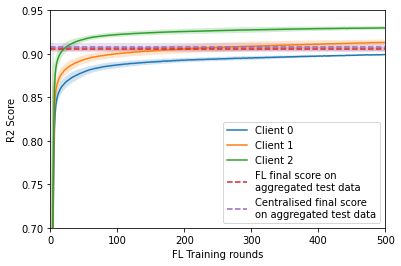

In [19]:
'''
show training curves
'''
%matplotlib inline

fl_r2_training_scores = np.asarray(fl_r2_training_scores)

for i in range(num_of_clients):
    plt.plot(np.mean(fl_r2_training_scores[:, :, i], axis=0), label='Client ' + str(i))
    plt.fill_between(x=np.arange(num_of_fl_rounds), 
                     y1=np.mean(fl_r2_training_scores[:, :, i], axis=0)+np.std(fl_r2_training_scores[:, :, i], axis=0),
                     y2=np.mean(fl_r2_training_scores[:, :, i], axis=0)-np.std(fl_r2_training_scores[:, :, i], axis=0),
                     alpha=0.2)

plt.plot(np.arange(num_of_fl_rounds), 
         np.ones(num_of_fl_rounds)*np.mean(fl_test_scores), 
         linestyle='dashed', 
         label='FL final score on\naggregated test data')
plt.fill_between(x=np.arange(num_of_fl_rounds),
                 y1=np.mean(fl_test_scores) + np.std(fl_test_scores),
                 y2=np.mean(fl_test_scores) - np.std(fl_test_scores),
                 alpha=0.2)



plt.plot(np.arange(num_of_fl_rounds), 
         np.ones(num_of_fl_rounds)*np.mean(central_scores), 
         linestyle='dashed', 
         label='Centralised final score\non aggregated test data')

plt.fill_between(x=np.arange(num_of_fl_rounds),
                 y1=np.mean(central_scores) + np.std(central_scores),
                 y2=np.mean(central_scores) - np.std(central_scores),
                 alpha=0.2)

plt.ylabel('R2 Score')
plt.xlabel('FL Training rounds')
plt.ylim([0.7, 0.95])
plt.xlim([0, num_of_fl_rounds])

plt.legend(loc='lower right')
plt.show()